In [11]:
import numpy as np
from select_lcss import LCSCandidate, Point
from matplotlib import pyplot as plt
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
#plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

from trivariatevectorbsplineinterpolation import SplineEigenvectorInterpolator
import sys
sys.path.insert(0,'../../')
sys.path.insert(0,'strain_prms_viljerun/')
from numerical_integrators.singlestep import rk4

In [19]:
from compute_manifolds import Manifold, GeodesicLevelSet, Point, InputManifoldParameters

In [20]:
xi1 = np.load('strain_prms_viljerun/xi1.npy')
xi2 = np.load('strain_prms_viljerun/xi2.npy')
xi3 = np.load('strain_prms_viljerun/xi3.npy')

x = np.load('strain_prms_viljerun/x.npy')
y = np.load('strain_prms_viljerun/y.npy')
z = np.load('strain_prms_viljerun/z.npy')

In [21]:
mf_cbc = np.load('./manifolds_cubic/0476_manifold_m.npy')[0]
mf_lin = np.load('./manifolds_linear/0476_manifold_m.npy')[0]


#mfm = np.load('./manifolds/0116_manifold_m.npy')[0]
#mfu = np.load('./manifolds/0116_manifold_u.npy')[0]
#mfd = np.load('./manifolds/0116_manifold_d.npy')[0]

In [67]:
xi1_itp_bspline = SplineEigenvectorInterpolator(x,y,z,xi1)
xi2_itp_bspline = SplineEigenvectorInterpolator(x,y,z,xi2)
xi3_itp_bspline = SplineEigenvectorInterpolator(x,y,z,xi3)

In [80]:
class RHS_ODEtrajectory:
    def __init__(self):
        pass
    
    def set_a(self,a):
        self.a = a
        self.b = np.sqrt(1-a**2)
    
    def set_pm(self,pm):
        self.pm = pm
        
    def __call__(self,t,x):
        return self.a*xi1_itp_bspline(x)+self.pm*self.b*xi2_itp_bspline(x)
    
class RHS_ODEtrajectory_2:
    def __init__(self):
        pass
    def set_tan_vec(self,a,pm,init_pos):
        self.vec = a*xi1_itp_bspline(init_pos) + pm*np.sqrt(1-a**2)*xi2_itp_bspline(init_pos)
    def set_prev_vec(self,v):
        self.prev_vec = v
    def __call__(self, t, x):
        v = np.cross(self.vec,xi3_itp_bspline(x))
        if np.dot(v,self.prev_vec) < 0:
            v = -v
        return v/np.linalg.norm(v)
        

In [83]:
def generate_trajectories(init_pos, t0, tf, h):
    _a = (np.arange(201)-100)/100
    _pm = [1,-1]
    
    func = RHS_ODEtrajectory_2()
    

    _p = []
    
    _strs = []
    
    for a in _a:

        #func.set_a(a)

        for pm in _pm:
            func.set_tan_vec(a,pm,init_pos)
            func.set_prev_vec(func.vec)
            #func.set_pm(pm)
            t = t0
            ps = [init_pos]
            _h = h
            p = ps[0]
            
            while t < tf:
                _h = min(_h,tf-t)
                v = func(t,p)
                t,p,_h = rk4(t,p,_h,func)
                func.set_prev_vec(v)
                ps.append(p)
            
            _p.append(np.asarray(ps))
            _strs.append('{:.3f}xi1{}{:.3f}xi2'.format(a,'+' if pm == 1 else '-',np.sqrt(1-a**2)))
            
    return _p, _strs

In [84]:
ps,strs = generate_trajectories(mf_cbc.input_params.init_pos, 0, 1.2, 0.01)
ps = np.asarray(ps)

In [85]:
mf_lin.geo_dist

1.1200000000000003

In [86]:
mf_cbc.geo_dist

1.6800000000000008

In [87]:
mf_cbc.set_xyzs()
mf_lin.set_xyzs()

<IPython.core.display.Javascript object>


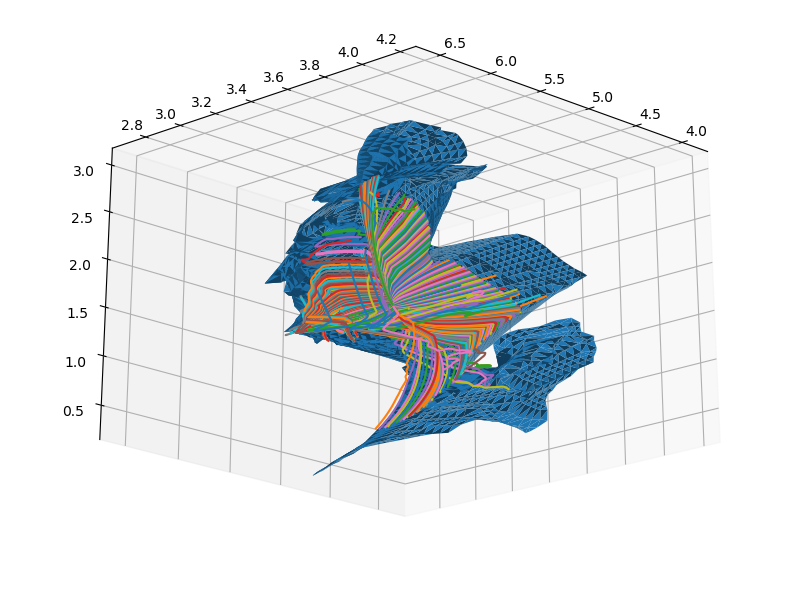

In [88]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111,projection='3d')
#ax2 = fig.add_subplot(122,projection='3d')

ax1.plot_trisurf(mf_cbc.xs, mf_cbc.ys, mf_cbc.zs, triangles = mf_cbc.triangulations)
#ax2.plot_trisurf(mfu.xs, mfu.ys, mfu.zs, triangles = mfu.triangulations)
#ax1.plot_trisurf(mf_lin.xs, mf_lin.ys, mf_lin.zs, triangles = mf_lin.triangulations)
for (ps_sq, s) in zip(ps,strs):
    ax1.plot(ps_sq[...,0],ps_sq[...,1],ps_sq[...,2],label=s)
 #   ax2.plot(ps_sq[...,0],ps_sq[...,1],ps_sq[...,2],label=s)

theta = 30
phi = -90

ax1.view_init(theta,phi)
#ax2.view_init(theta,phi)
plt.tight_layout()

In [10]:
def funkygibbons():
    q = np.load('lcss.npy')
    l = q[:2].copy()
    del q
    return l

def extract_stuff():
    LCSs = funkygibbons()
    x, y, z, triangs = [], [], [], []
    for l in LCSs:
        x.append(l.xs)
        y.append(l.ys)
        z.append(l.zs)
        triangs.append(l.triangulations)
    np.save('gx.npy',x)
    np.save('gy.npy',y)
    np.save('gz.npy',z)
    np.save('gt.npy',triangs)
    print('keklord')

In [11]:
LCSs = funkygibbons()

<IPython.core.display.Javascript object>


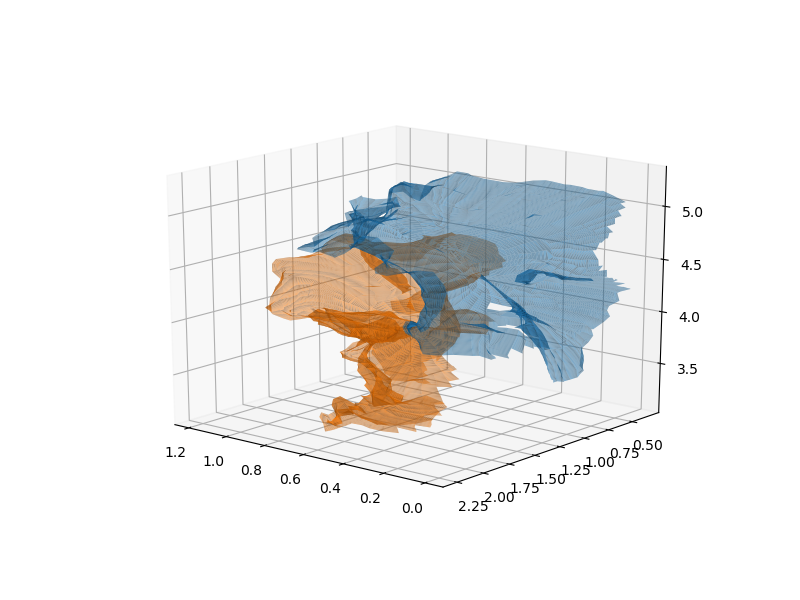

In [12]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

for l in LCSs:
    ax.plot_trisurf(l.xs, l.ys, l.zs, triangles = l.triangulations,alpha=0.55)



IndexError: index 11 is out of bounds for axis 0 with size 10

In [12]:
np.shape(LCSs[0].triangulations)

(12571, 3)